## Practical Exercise 1: An Introduction to Word Embeddings and Word2Vec

Before we start, we would like to highlight that each of the three notebooks will contribute equally to your final grade.

This practical Exercise is presented as an IPython Notebook, with the code written for recent versions of **Python 3**.

Before working with this notebook, you need to execute some of the pre-coded cells (to load libraries/functions/modules etc.). To execute one notebook cell, press `shift-enter`. The return value of the last command will be displayed, if it is not `None`.

Below is a list with potentially useful library documentation, references, and resources:

* IPython notebooks: <https://ipython.org/ipython-doc/3/notebook/notebook.html#introduction>
* Numpy numerical array library: <https://docs.scipy.org/doc/>
* Gensim's word2vec: <https://radimrehurek.com/gensim/models/word2vec.html>
* Bokeh interactive plots: <http://bokeh.pydata.org/en/latest/> (we provide plotting code here, but click the thumbnails for more examples to copy-paste)
* scikit-learn ML library (aka `sklearn`): <http://scikit-learn.org/stable/documentation.html>
* nltk NLP toolkit: <http://www.nltk.org/>
* tutorial for processing xml in python using `lxml`: <http://lxml.de/tutorial.html> (we did this for you below, but in case you need it in the future)

#### Introduction & imports

In this notebook you will familiarize yourselves with constructing and using word-embeddings. As you recall from the lecture, word-embeddings are a type of word representation that allow words with similar meaning to have similar representations. This can be achieved by representing words as real-valued vectors in a predefined vector space. However, before delving into the embedding process, you will need to learn how to use some basic NLP tools like tokenization and regular expressions!
Good Luck and happy coding!

In [1]:
# Importing necessary libraries/modules; requires to be executed once for every session
import numpy as np
import matplotlib.pyplot as plt
import os
from random import shuffle
import re
import nltk

from bokeh.models import ColumnDataSource, LabelSet
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook
output_notebook()
nltk.download('punkt')

!pip install wordcloud
from wordcloud import WordCloud

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
# Here we install nltk. You only have to execute this cell once!
try:
    import nltk
except:
    import sys
    !{sys.executable} -m pip install nltk
    import nltk
    nltk.download()

### Part 0: Download the TED dataset

For this practical exercise, we need a large amount of text data. We will use the TED database, which are the transcripts of Ted Talks. The next cells will download everything you need, this might take a while as the dataset is 75MB large.

In [2]:
import zipfile
import lxml.etree

In [3]:
# Upload the dataset if it's not already there: this may take a minute..
if not os.path.isfile('ted_en-20160408.zip'):
  from google.colab import files
  # select the file "ted_en-20160408.zip" from your local drive here
  uploaded = files.upload()

Saving ted_en-20160408 (2).zip to ted_en-20160408 (2).zip


In [3]:
# For now, we're only interested in the subtitle text, so let's extract that from the XML:
with zipfile.ZipFile('ted_en-20160408 (2).zip', 'r') as z:
    doc = lxml.etree.parse(z.open('ted_en-20160408.xml', 'r'))
input_text = '\n'.join(doc.xpath('//content/text()'))

print(type(input_text))

<class 'str'>


To give you a little bit of an idea about the structure of the dataset, you can open the `xml` file inside the zip folder and have a look at it. The dataset consists of metadata or properties of TedTalks, such as speaker information, language, transcripts, tags, date, and much more.

As you can see, the `xml` file has lots of different tags to mark the beginning and end of the particular datapoint. The code cell bellow shows the tags that are inside the `xml` file. As you can already imagine, the tags are used to mark different properties of the data. For this assignment, we are interested in the content/text only, which is the reason for extracting the text from the content tag and from it, create the text data.

In [4]:
# Extract all the tags in the XML
tags = [element.tag for element in doc.iter()]

# Get unique tags using a set
unique_tags = set(tags)

# Print the unique tags
for tag in unique_tags:
    print(tag)

# Delete the variable doc to save space as we have alreay extracted the necessary data we need.
del doc

title
speaker
content-type
transcriber
reviewer
url
dtime
keywords
talkid
xml
encoding
content
videopath
seekvideo
translators
pagesize
head
file
transcription
videourl
reviewers
translator
description
charnum
date
wordnum
transcribers


### Part 1: Preprocessing

Although language oftentimes follows strict rules and structures, text datasets in practice are often noisy. Before we can use our text data, we therefore need to clean it. This process is called *preprocessing*. If we don't do this, the data may be inconsistent and therefore more difficult to analyze and work with. You may ask yourself, what exactly do we need to clean, where exactly would we expect inconsistencies? Take a moment and think about it potential hickups in the raw data. What we need to do, is to preprocess the text and bring it into a clean and consistent format, allowing further analyzing steps.

<h4>Exercise 1.1 (3 Points)</h4>



The following part of the code shows a chunk of text from our ted text dataset. Have a look and try to identify **three** issues you can think of that can create a problem for text analysis, next to the one which is already provided. When giving your answer, we ask you to also mention **why** the issues could be problematic (similar to the example given). Each correct answer (naming + explaining the problem) will give 1 point.

In [5]:
# Have a look at the output of this code, to see some text examples.
i = input_text.find("Hyowon Gweon: See this?")
print(input_text[i:i+300])
print()

i = input_text.find("You will earn")
print(input_text[i:i+45])

Hyowon Gweon: See this? (Ball squeaks) Did you see that? (Ball squeaks) Cool. See this one? (Ball squeaks) Wow.
Laura Schulz: Told you. (Laughs)
(Video) HG: See this one? (Ball squeaks) Hey Clara, this one's for you. You can go ahead and play. (Laughter)
LS: I don't even have to talk, right? All rig

You will earn 10% of any gold you distributes


<b>Your Solution goes here:</b>
<br>- Speakers' names: embeddings for names will dominate the embedding space unnecessarily.
<br>- (Output sentences are incomplete ("All rig") -> because of wrong array)
<br>- Background noises are inlcuded "(Ball squeaks)"
<br>- punctuation marks: are unnecessary work when searching a dataset

<h4>Exercise 1.2 (9 Points)</h4>

Next we want to create a preprocessing pipeline to later clean the entire dataset in one go. The pipeline takes `input_text` as input and should provide a cleaned and ready-to-use text data called `cleaned_text`.

Your task is to implement this pipeline with **three** functions that each take care of **one** of the **three** issues you listed in exercise 1.1.

Some hints about the pipeline are given as well as the code for the example from 1.1.

In [6]:
#import re
import string

def remove_speaker(text):
  ''' takes the text as an input and removes the name of the speaker as output '''
  #input_text = text

  X = []
  for line in input_text.split('\n'):
      #print(line)
      m = re.match(r'^(?:(?P<precolon>[^:]{,20}):)?(?P<postcolon>.*)$', line)
      X.extend(m.groupdict()['postcolon'])
  without_speaker="".join(X)
  return without_speaker


# The three functions:

def remove_noises(input_text): # takes text as input and removes background noises (like "(laughs)")
  text = re.sub(r'\(\)', '', input_text) # remove anything with parentheses in the dataset
  return text

def remove_punctuations(input_text): # removes punctuation marks
  text = input_text.translate(str.maketrans('', '', string.punctuation))
  return text

# def ...



def text_cleaned(input_text):

  ''' takes the raw text as input. Runs the text through cleaning functions.
       outputs a clean an preprocessed text for further analysis. '''

  # Our three functions:
  text_no_speaker = remove_speaker(input_text)
  text_no_noises = remove_noises(text_no_speaker)
  text_no_punctuations = remove_punctuations(text_no_noises)
  text_cleaned = text_no_punctuations

  return text_cleaned

input_text_cleaned = text_cleaned(input_text)
print(input_text_cleaned[i:i+200])

 theyre watching their shows actually they are being watched They are being watched by Roy Price and his team who record everything They record when somebody presses play when somebody presses pause w


<h4>Exercise 1.3 (6 Points)</h4>

To continue with building our embedding, we need to tokenize every single word (so that the model has individual tokens to process). Therefore we first need to split the text into sentences and after that into words.
Try it yourselves or use the NLTK-Tools build for this (https://www.kite.com/python/docs/nltk.word_tokenize + https://www.kite.com/python/docs/nltk.sent_tokenize).
To make it easier, we should also delete every character that is not a letter. Additionally, we could decrease the size of our vocabulary. A way to do this is by converting capital characters to lower case characters (but it also has some drawbacks - more on this in exercise 1.4).<br>

Split your text into sentences and save them in the array `sentences_strings_ted`.
Save one variabale `tokens` with all the tokens in the text and one array named `sentences_ted` that contains an array for every sentence, with all the tokenized words of that sentence.<br><br>
Example:<br>
If the text looks like this: "I love cake. You have to be honest, you love it too!", the variables should look like:<br>
sentences_strings_ted=['I love cake.', 'You have to be honest, you love it too!']<br>
sentences_ted=[['i', 'love', 'cake'], ['you', 'have', 'to', 'be', 'honest', 'you', 'love', 'it', 'too']]<br>
tokens=['i', 'love', 'cake', 'you', 'have', 'to', 'be', 'honest', 'you', 'love', 'it', 'too']<br><br>

IMPORTANT: Apply this to `input_text_clean`.<br><br>


 **[Hint:]** use pickle file (.pkl) to dump and load the variables like `sentences_strings_ted`, `tokens`, `sentences_ted` to continue where you left, when you comeback next time. It will save a lot of time/effort.

In [28]:
from nltk.tokenize import sent_tokenize, word_tokenize
from IPython.display import FileLink

# sentences_strings_ted:
sentences_strings_ted = nltk.sent_tokenize(input_text_cleaned)

# tokens:
tokens = nltk.word_tokenize(input_text_cleaned)

# sentences_ted:
def create_sentences_array(input_text_cleaned):
    sentences_ted = nltk.sent_tokenize(input_text_cleaned)
    return sentences_ted

sentences_array = create_sentences_array(input_text_cleaned)

# print(nltk.word_tokenize(input_text_cleaned))


'''
# print the sentences and tokens:
print("sentences_strings_ted:")
print(sentences_strings_ted)

print("\n sentences_ted:")
for sentence in sentences_array[0:10]:
  print(sentence)

print("\n tokens:")
print(tokens)

# limit the output
PAGE_SIZE = 1
for i in range(0, len(sentences_array), PAGE_SIZE):
    print(sentences_array[i:i+PAGE_SIZE])




import pickle #pickle file to dump & load the variable

pickle_file_path = 'tokenization.pkl'

with open(pickle_file_path, 'wb') as pickle_file:
  pickle.dump((sentences_strings_ted, sentences_array), pickle_file)

with open('preprocessed_data.pkl', 'rb') as pickle_file:
  sentences_strings_ted, sentences_array = pickle.load(pickle_file)'''




# Save the output to a file
output_filename = "output.txt"
with open(output_filename, "w") as f:
    f.write("\n".join(sentences_array))

# Display a link to download the file
FileLink(output_filename)

/content/output.txt

<h4>Exercise 1.4 (1 Point)</h4>

The good side of converting all capital letters is, that we reduce the volume of the vocabulary. Thereby we dont differentiate between the the words "today" and "Today". But there is a caveat. Can you think of any downside to this process?

**Your answer goes here:**
By converting all capital letters, we lose information about the meaning and the part of speech of the word, so for instance if it is a noun or an adjective etc.
Also, it can cause contextual ambiguity.

Let's quickly see how large our vocabulary turned out to be!

In [29]:
with open(output_filename, "r") as f:
    loaded_data = f.read()

len(sentences_ted)

NameError: ignored

### Part 2: Word Frequencies

<h4>Exercise 2.1 (2 Points)</h4>

Your next task will be to store the counts of the top 1,000 most frequent words in a list called `counts_ted_top1000` ! There are multiple ways to do this. You can have a look at the Counter-Function (https://docs.python.org/2/library/collections.html) or the FreqDist-Function (https://www.kite.com/python/docs/nltk.FreqDist). If you don't trust any of these, you can of course build your own function. In the end we want an array with tuples of the structure:

counts_ted_top1000 =  [(WordA,FrequencyA),(WordB,FrequencyB)]

In [19]:
from nltk.probability import FreqDist
freq_dist = FreqDist(tokens)
counts_ted_top1000 = freq_dist.most_common(1000)

# Print the top 1000 most frequent words
print("The 1000 most frequent words are:")
for word, frequency in counts_ted_top1000:
    print(f"{word}, {frequency}")

The 1000 most frequent words are:
the, 195496
to, 124137
of, 114250
and, 106265
a, 102782
that, 82038
in, 72990
I, 65610
is, 62480
you, 54134
we, 45729
it, 43971
this, 40619
And, 38248
was, 30688
for, 28253
are, 27516
have, 27092
on, 25038
with, 24282
they, 21231
about, 21020
can, 20904
be, 19999
what, 19865
not, 18644
at, 18458
as, 18195
all, 17556
do, 16970
its, 16443
my, 16236
like, 15624
people, 15440
So, 15436
were, 15294
one, 15140
from, 15136
so, 15076
but, 14203
an, 13708
our, 13411
just, 13230
or, 13053
there, 12277
these, 12274
if, 12157
very, 12155
me, 11952
out, 11876
know, 11385
by, 11368
going, 11307
them, 11214
up, 10951
when, 10907
had, 10866
because, 10757
more, 10626
The, 10424
But, 10269
think, 10166
see, 9912
their, 9853
your, 9781
We, 9726
would, 9698
which, 9674
really, 9553
how, 9528
who, 9312
get, 9261
he, 8976
us, 8490
Im, 8423
then, 8324
has, 8218
time, 8176
Its, 8147
some, 7889
into, 7845
actually, 7761
dont, 7753
will, 7468
world, 7447
way, 7443
here, 7398
y

The following code is going to plot a histogram with the counts of the  top-30 words as bars.

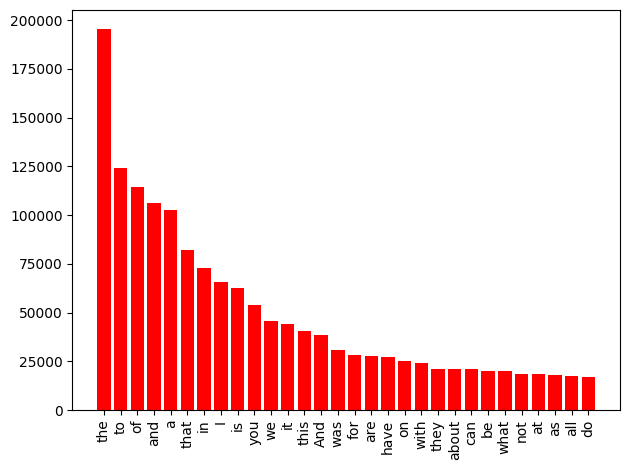

In [20]:
mostfreqn=30 # Here we define how many of them we want to see in the diagramm
frequency=[y for (x,y) in counts_ted_top1000][:mostfreqn]
word=[x for (x,y) in counts_ted_top1000][:mostfreqn]
indices = np.arange(len(counts_ted_top1000[:mostfreqn]))
plt.bar(indices, frequency, color='r')
plt.xticks(indices, word, rotation='vertical')
plt.tight_layout()
plt.show()

Exercise: You can clearly see, that many of the most common words are redundant and not very meaningful. These types of words are called **stopwords**. What problems can stop words create in the NLP and why it is important to remove them?

**Your answer goes here:**
Stop words can decrease processing speed since there is a large number of such words in a text. Also, they impair the extraction of essential information since they occupy the storage.

<h4>Exercise 2.2 (2 Points)</h4>

Now, write a function that removes the stopwords from the variable `counts_ted_top1000` and save it as `counts_ted_top1000_no_stopword`. Use the code for visualization and spot the differences.

The structure in the end should look like this: counts_ted_top1000_no_stopword = [(WordA,FrequencyA),(WordB,FrequencyB)]

In [23]:
import nltk
nltk.download('stopwords')

def remove_stopwords(counts_ted_top1000):
    stop_words = set(stopwords.words('english'))
    counts_ted_top1000_no_stopword = [word for word in counts_ted_top1000] #if word.lower() not in stop_words]
    return counts_ted_top1000_no_stopword

result = remove_stopwords(counts_ted_top1000)
print(result)

[('the', 195496), ('to', 124137), ('of', 114250), ('and', 106265), ('a', 102782), ('that', 82038), ('in', 72990), ('I', 65610), ('is', 62480), ('you', 54134), ('we', 45729), ('it', 43971), ('this', 40619), ('And', 38248), ('was', 30688), ('for', 28253), ('are', 27516), ('have', 27092), ('on', 25038), ('with', 24282), ('they', 21231), ('about', 21020), ('can', 20904), ('be', 19999), ('what', 19865), ('not', 18644), ('at', 18458), ('as', 18195), ('all', 17556), ('do', 16970), ('its', 16443), ('my', 16236), ('like', 15624), ('people', 15440), ('So', 15436), ('were', 15294), ('one', 15140), ('from', 15136), ('so', 15076), ('but', 14203), ('an', 13708), ('our', 13411), ('just', 13230), ('or', 13053), ('there', 12277), ('these', 12274), ('if', 12157), ('very', 12155), ('me', 11952), ('out', 11876), ('know', 11385), ('by', 11368), ('going', 11307), ('them', 11214), ('up', 10951), ('when', 10907), ('had', 10866), ('because', 10757), ('more', 10626), ('The', 10424), ('But', 10269), ('think', 10

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [24]:
mostfreqn=30 # Here we define how many of them we want to see in the diagramm
frequency=[y for (x,y) in counts_ted_top1000_no_stopword][:mostfreqn]
word=[x for (x,y) in counts_ted_top1000_no_stopword][:mostfreqn]
indices = np.arange(len(counts_ted_top1000_no_stopword[:mostfreqn]))
plt.bar(indices, frequency, color='r')
plt.xticks(indices, word, rotation='vertical')
plt.tight_layout()
plt.show()

NameError: ignored

#### Wordcloud Visualization

The below so-called **wordcloud** shows the most frequent words in a larger font and the less frequent ones in a smaller font size. It's a quick and cool way of visualizing the most frequent words!

In [25]:
# Create a dictionary that maps words to their frequencies
counts_ted_top1000_no_stopword = {word: count for word, count in counts_ted_top1000_no_stopword}

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white')

# Generate the word cloud
wordcloud.generate_from_frequencies(counts_ted_top1000_no_stopword)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

NameError: ignored

### Part 3: Generating the Word Embeddings with Word2Vec

Now it is time to run the embedding model. Gensim has an already implemented model that you can use. Using the provided model is enough for the purposes of our notebook. If you want to dive deeper into the topic - this youtube video https://www.youtube.com/watch?v=kKDYtZfriI8 could be a great guidance for you to get started.

In [30]:
# This takes a moment.. dont worry :D
from gensim.models import Word2Vec

model_ted = Word2Vec(sentences_ted)

NameError: ignored

### Part 4: Inspection of our learned representations/embeddings (3 Points)


Now that we have a model that captures the word embeddings, we can use it to explore properties of the words in the text.

First, code a line that looks at the embedding of one individual word/token.  What does the representation of "house" look like in the embedding model? You may refer to the following gensim docs for functions, that might help you https://radimrehurek.com/gensim/models/keyedvectors.html). This will give you 1 point.

In [48]:
word = "house"

word_embedding = word_vectors[word]
print(f"The embedding for the word '{word}' is: {word_embedding}")

The embedding for the word 'house' is: [-0.18867   -0.040943   0.58878    0.11062    0.14236    0.4885
 -0.31832    0.53819   -0.018549   0.029687   0.30299   -0.16522
 -0.18896    0.5148    -0.79405    0.26409    0.027747   0.041163
 -0.49378   -0.14263    0.29017   -0.25369    0.70559   -1.0501
 -0.49344   -0.37148   -0.85796   -0.55158   -0.60251   -0.0099676
  0.8725     0.12149    0.551      0.49924   -0.3088     1.1067
 -0.15494   -0.29923    0.91149    0.19859   -0.73946   -1.0182
  0.37208   -0.10043    0.13537   -0.52687   -0.60437   -0.15906
  0.49283   -0.61386    0.046815  -0.88806    0.60229    0.72199
 -0.4316    -3.0706    -0.11233   -0.45713    0.95737    0.59174
 -0.17124    0.65746    0.44741    0.6101     1.0216    -0.2458
  0.90191    0.78319    0.28272   -0.4539     0.16309   -0.0078932
 -0.27714   -0.87249   -0.19716   -0.076285  -0.28422   -0.089584
 -1.3132     0.16372   -0.25441   -0.076529   0.44458   -0.17525
 -0.74084   -0.25415    0.52886   -0.46958    0.16

The next task for you is to output the most similar word to "town"? This will also give you 1 point.

In [49]:
word = "town"


similar_words = word_vectors.most_similar(word)
most_similar_word, similarity_score = similar_words[0]
print(f"The most similar word to '{word}' is '{most_similar_word}'.")

The most similar word to 'town' is 'village'.


Finally, we want to find out how similar the words "town" and "house" are. Again: 1 point for this!

In [50]:
word1 = "town"
word2 = "house"

similarity_score = word_vectors.similarity(word1, word2)
print(f"The cosine similarity between '{word1}' and '{word2}' is: {similarity_score:.4f}")

The cosine similarity between 'town' and 'house' is: 0.5310


<h4>Exercise 4.1 (3 Points)</h4>


Now that we have generated our embeddings, let's test some classical ideas:
implement the following formula. Print out the 10 words, that are most similar to this formula: <br>
$King-Man+Woman=???$
There are two ways of computing similarity in word embeddings:
 - https://tedboy.github.io/nlps/generated/generated/gensim.models.Word2Vec.most_similar.html
 - https://tedboy.github.io/nlps/generated/generated/gensim.models.Word2Vec.most_similar_cosmul.html
You should try out both! In this case one of them is better, but both of them are valid methods for computing similarity in the word-space.

In [ ]:
# Your implementation goes here.

Exercise 4.2 (2 Points)

The expected outcome (Queen) should be one of the top ten most similar words. But there are also a lot of words, that you would not expect. Think about where how these words might be connected to the formula. Take your time and understand why some of the words (luther, mary, dr, president) might be in this list.

**Your answer goes here:**

#### t-SNE visualization

We will use the t-SNE algorithm, given below, for visualization. The so-called t-Distributed Stochastic Neighbor Embedding (t-SNE) is an unsupervised and non-linear machine learning technique. It is commonly used for visualizing high dimensional data (just like our high dimensional vectors). You do not have to understand the code, its purpose is simply to give you an idea of how the data is arranged in high dimensional space.

<h4>Exercise 4.3 (2 Points)</h4>

To use the t-SNE code below, first put a list of the top 50 words (as **strings**, without **stopwords**) into a variable `words_top_ted`.

In [ ]:
# Your implementation goes here.

The following code gets the corresponding vectors from the model, assuming it's called `model_ted`:

In [ ]:
# This assumes words_top_ted is a list of strings, the top 250 words
words_top_vec_ted = model_ted.wv[words_top_ted]

The next few lines are for the t-SNE visualization.

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
words_top_ted_tsne = tsne.fit_transform(words_top_vec_ted)

In [ ]:
p = figure(tools="pan,wheel_zoom,reset,save",
           toolbar_location="above",
           title="word2vec T-SNE for most common words")

source = ColumnDataSource(data=dict(x1=words_top_ted_tsne[:,0],
                                    x2=words_top_ted_tsne[:,1],
                                    names=words_top_ted))

p.scatter(x="x1", y="x2", size=8, source=source)

labels = LabelSet(x="x1", y="x2", text="names", y_offset=6,
                  text_font_size="8pt", text_color="#555555",
                  source=source, text_align='center')
p.add_layout(labels)

show(p)

That's it. We hope you had fun and learned something in the process :-)